In [153]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import math

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, classification_report, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


# Simple Prep Stuff

In [2]:
TEST_PATH = "./DataLivesHere/test.csv"
TRAIN_PATH = "./DataLivesHere/train.csv"

In [3]:
test_df = pl.read_csv(TEST_PATH)
train_df = pl.read_csv(TRAIN_PATH)

# Exploratory Data Analysis

Where are the nulls in the Train SET
shape: (1, 9)
┌───────┬──────────┬──────────┬───────────┬───┬────────────┬─────────┬─────┬─────┐
│ Dates ┆ Category ┆ Descript ┆ DayOfWeek ┆ … ┆ Resolution ┆ Address ┆ X   ┆ Y   │
│ ---   ┆ ---      ┆ ---      ┆ ---       ┆   ┆ ---        ┆ ---     ┆ --- ┆ --- │
│ u32   ┆ u32      ┆ u32      ┆ u32       ┆   ┆ u32        ┆ u32     ┆ u32 ┆ u32 │
╞═══════╪══════════╪══════════╪═══════════╪═══╪════════════╪═════════╪═════╪═════╡
│ 0     ┆ 0        ┆ 0        ┆ 0         ┆ … ┆ 0          ┆ 0       ┆ 0   ┆ 0   │
└───────┴──────────┴──────────┴───────────┴───┴────────────┴─────────┴─────┴─────┘
['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']


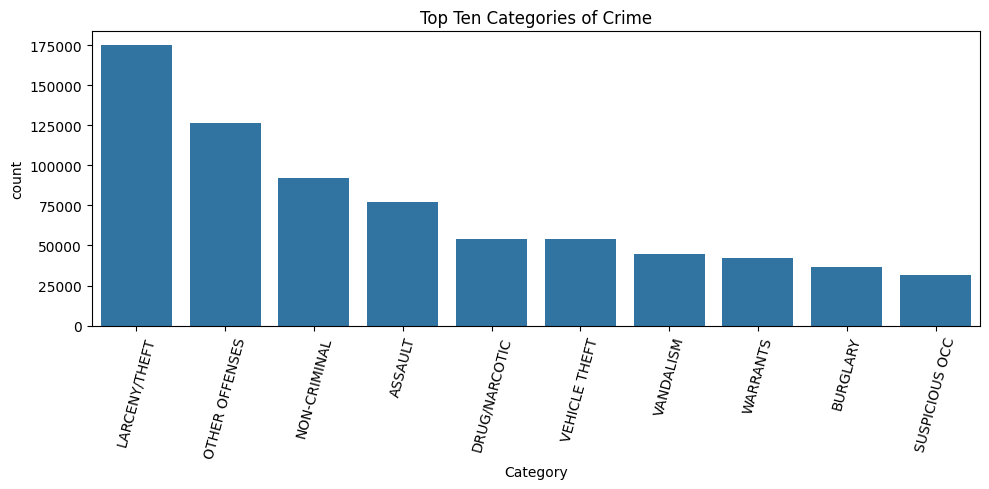

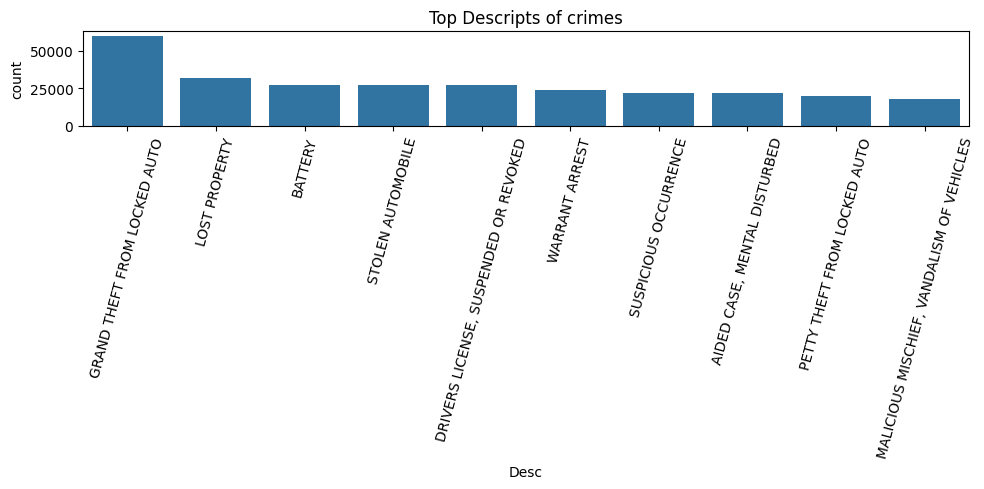

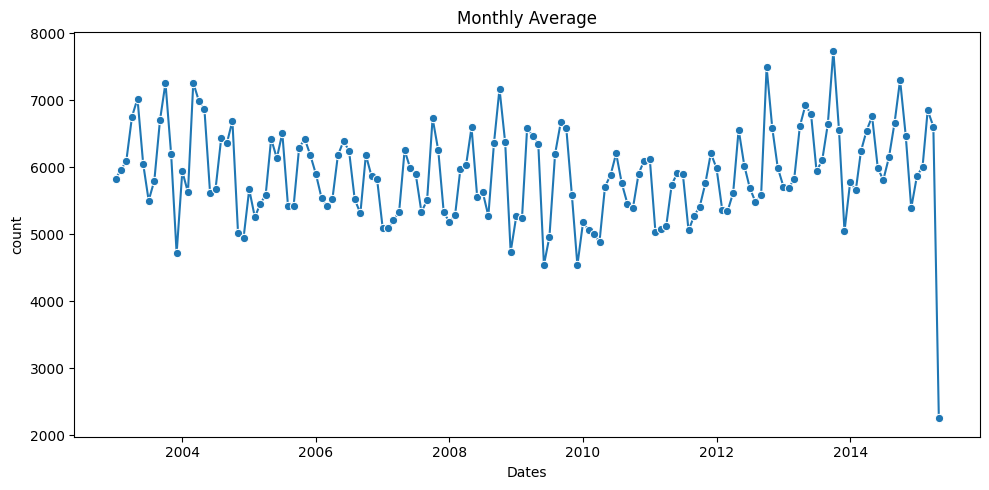

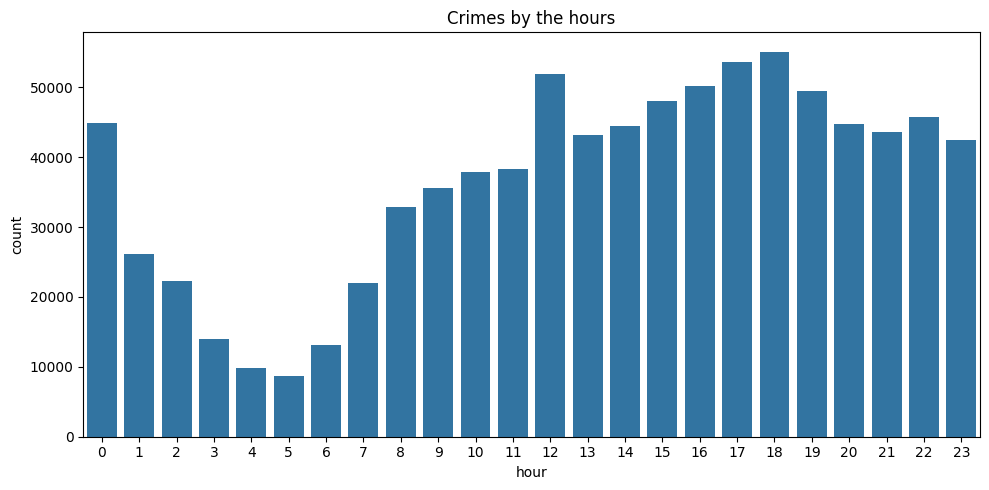

In [ ]:
def eda(df):
    print("Where are the nulls in the Train SET")
    print(df.null_count())
    print(df.columns)

    dates_todate = (df.with_columns(
                pl.col("Dates").str.to_datetime()
            ).sort("Dates")
    )


    plt.figure(figsize=(10,5))

    cate = (df.get_column("Category")
                  .to_pandas()
                  .dropna()
                  .value_counts()
                  .head(10)
                  .rename_axis("Category")
                  .reset_index(name="count")
            )
    sns.barplot(data=cate, x="Category", y="count")
    plt.title("Top Ten Categories of Crime")
    plt.xticks(rotation=75)
    plt.tight_layout()

    plt.figure(figsize=(10,5))
    desc = (df.get_column("Descript")
            .to_pandas()
            .dropna()
            .value_counts()
            .head(10)
            .rename_axis("Desc")
            .reset_index(name="count")
            )
    
    sns.barplot(data=desc, x="Desc", y="count")
    plt.title("Top Descripts of crimes")
    plt.xticks(rotation=75)
    plt.tight_layout()

    plt.figure(figsize=(10,5))
    dates_dynamic = dates_todate.group_by_dynamic(
        index_column="Dates",
        every="1mo",
        offset="0h",
        closed="left",
    ).agg(
        pl.len().alias("count")
    ) # This is so fucking powerful holy shit.
    sns.lineplot(data=dates_dynamic,  x="Dates", y="count", marker="o")
    plt.title("Monthly Average")
    plt.tight_layout()

    plt.figure(figsize=(10,5))
    hours_dym = (dates_todate
        .with_columns(pl.col("Dates").dt.hour().alias("hour"))
        .group_by("hour")
        .agg(pl.len().alias("count"))
        .sort("hour")
    )
    sns.barplot(data=hours_dym, x="hour", y="count")
    plt.title("Crimes by the hours")
    plt.tight_layout()

eda(train_df)


# Feature Stuff

In [83]:
def fe(df):
    th = df.clone()

    th = th.with_columns(
        pl.col("Dates").str.strptime(pl.Datetime, strict=False).alias("Dates_dt")
        # If your Polars version prefers it:
        # pl.col("Dates").str.to_datetime().alias("Dates_dt")
    ).with_columns(
        pl.col("Dates_dt").dt.year().alias("Year"),
        pl.col("Dates_dt").dt.month().alias("month"),
        pl.col("Dates_dt").dt.day().alias("day"),
        pl.col("Dates_dt").dt.hour().alias("hour"),
        pl.col("Dates_dt").dt.minute().alias("minute"),
        pl.col("Dates_dt").dt.second().alias("second"),
        pl.col("Dates_dt").dt.weekday().alias("weekday"),
    ).drop("Dates_dt")

    th = th.with_columns(
       pl.when(pl.col("weekday") > 5).then(True).otherwise(False).alias("is_weekend")
    )

    th = th.with_columns(
        (
            (pl.col("hour") + pl.col("minute")/60 + pl.col("second")/3600)
            .cast(pl.Float64) * (2 * math.pi/24)
        )
        .sin().alias("sin_hr"),
       ( 
            (pl.col("hour") + pl.col("minute")/60 + pl.col("second")/3600)
            .cast(pl.Float64) * (2 * math.pi/24)
        )
       .cos().alias("cos_hr")
    )
    
    th = th.with_columns(
        (
            (pl.col("weekday"))
            .cast(pl.Float64) * (2 * math.pi/7)
        ).sin().alias("sin_dow"),
        (
            (pl.col("weekday"))
            .cast(pl.Float64) * (2 * math.pi/7)
        ).cos().alias("cos_dow")
    )

    th = th.with_columns(
        pl.col("Address").fill_null(strategy="forward").alias("addy")
    ).with_columns(
        pl.col("addy").str.contains("/", strict=False).cast(pl.Int8).alias("isIntersection")
    ).with_columns(
        pl.col("addy").str.contains("Block", strict=False, literal=False).cast(pl.Int8).alias("isBlock")
    ).drop("addy")

    LAT0, LON0 = 37.7749, -122.4194
    R_KM = 6371.0088
    DEG2RAD = math.pi / 180.0
    COS_LAT0 = math.cos(LAT0 * DEG2RAD)

    th = (th
        .with_columns(
            dlat = (pl.col("Y") - LAT0) * DEG2RAD,
            dlon = (pl.col("X") - LON0) * DEG2RAD,
            latr =  pl.col("Y") * DEG2RAD,
        )
        .with_columns(
            a = ((pl.col("dlat")/2).sin()**2)
              + (pl.col("latr").cos() * COS_LAT0 * (pl.col("dlon")/2).sin()**2)
        )
        .with_columns(  # define a_clamp in its own call
            a_clamp = (pl.when(pl.col("a") < 0).then(0.0)
                         .when(pl.col("a") > 1).then(1.0)
                         .otherwise(pl.col("a")))
        )
        .with_columns(  # now you can use a_clamp
            (2.0 * pl.arctan2(pl.col("a_clamp").sqrt(), (1.0 - pl.col("a_clamp")).sqrt()) * R_KM)
                .cast(pl.Float32)
                .alias("dist_km_center"),
            pl.col("X").round(2).cast(pl.Float32).alias("X_round2"),
            pl.col("Y").round(2).cast(pl.Float32).alias("Y_round2"),
        )
        .drop(["dlat","dlon","latr","a","a_clamp"])
    )


    return th

In [99]:
continuous_cols = [
    "X", "Y", "dist_km_center", "X_round2", "Y_round2",
    "Year",               
    "sin_hr", "cos_hr",     
    "sin_dow", "cos_dow", 
]

categorical_cols = [
    "PdDistrict",
    "is_weekend", "isIntersection", "isBlock",
]


In [85]:
test = fe(test_df)
train = fe(train_df)

# Feature Encoding

In [92]:
test_pd = test.to_pandas()
train_pd = train.to_pandas()

In [101]:
le = LabelEncoder()
y = le.fit_transform(train_pd["Category"])
class_names = list(le.classes_)
n_classes = len(class_names)
print(f"Classes: {n_classes}, {class_names}")

Classes: 39, ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']


In [146]:
x_df = train_pd[categorical_cols + continuous_cols]
x_train, x_val, y_train, y_val = train_test_split(
    x_df, y, train_size=0.25, stratify=y, random_state=42
)


# Model Stuff

In [ ]:
def model_metrics(y_true, y_pred, class_names= None):
    labels = sorted(set(y_true) | set(y_pred))
    #need to grpah this later
    cm = confusion_matrix(y_true, y_pred, labels=labels).astype(float)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    reC = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    df = pd.DataFrame({
        "Accuracy": acc,
        "f1_Score": f1,
        "recall": reC,
        "Precision": precision
    })

    return df, cm
    

In [148]:
preprocess_linear = ColumnTransformer([
    ("num", StandardScaler(), continuous_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["PdDistrict"]),
    ("bool", "passthrough", ["is_weekend","isIntersection","isBlock"]),
])

preprocess_tree = ColumnTransformer([
    ("num", "passthrough", continuous_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["PdDistrict"]),
    ("bool", "passthrough", ["is_weekend","isIntersection","isBlock"]),
])

preprocess_svm = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
        ("bool", "passthrough", ["is_weekend","isIntersection","isBlock"]),
    ],
    sparse_threshold=1.0
)

In [120]:
logit = Pipeline([
    ("prep", preprocess_linear),
    ("logit", LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        solver="newton-cg",
    ))
])

#logit.fit(x_train, y_train)

In [142]:
rf = Pipeline([
    ("prep", preprocess_linear),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=7,
        criterion="gini",
        random_state=42
    ))
])

#rf.fit(x_train, y_train)

In [150]:
linear_svc = Pipeline([
    ("prep", preprocess_svm),
    ("Linsvm", LinearSVC(
        C=1.0, class_weight="balanced", dual="auto"
    ))
])
#linear_svc.fit(x_train, y_train)

In [126]:
X_test = test[categorical_cols + continuous_cols]
#test_pred_ids = logit.fit_perdict(X_test)
#test_pred_labels = le.inverse_transform(test_pred_ids)

test_pred_ids = rf.predict(X_test)
test_pred_lables = le.inverse_transform(test_pred_ids)

[ 1 21 16 ... 36  1 16]
['ASSAULT' 'OTHER OFFENSES' 'LARCENY/THEFT' ... 'VEHICLE THEFT' 'ASSAULT'
 'LARCENY/THEFT']
